Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети

Данная модель пытается сгенерировать несуществующих аниме персонажей
Обучение будем проводить на 20тыс изображений 64*64 пикселя

Загрузка библиотек

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers.legacy import Adam, SGD
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.keras.layers import BatchNormalization
from google.colab import drive
import zipfile
from gzip import GzipFile

Подготовка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Путь к архиву с данными и его распаковка
zip_file = '/content/drive/MyDrive/data.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()


In [3]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0

    imagePaths = list(list_images(directory))

    for path in imagePaths:

        if not('OSX' in path):

            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return images

In [7]:
images=load_images('/content/data')

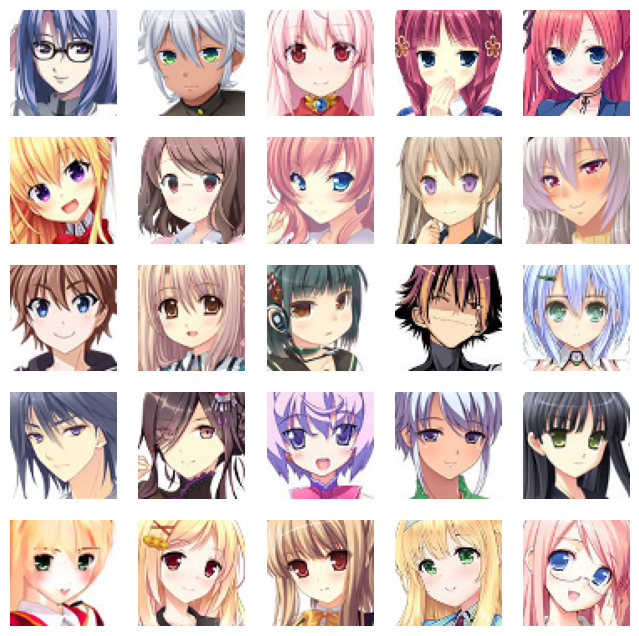

In [8]:
_,ax = plt.subplots(5,5, figsize = (8,8))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[6*i+j])
        ax[i,j].axis('off')

In [28]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)

        self.noise_size = 100

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)

        self.discriminator.trainable = False

        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined.summary()

    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)

        model = Sequential()

        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))

        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, (5,5), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5,5), padding='same'))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.5))

        model.add(Conv2D(64, (5,5), padding='same'))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5,5), padding='same'))
        model.add(LeakyReLU(alpha=0.3))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)

        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise, verbose=0)

            # Training the discriminator

            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)

            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss

            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0

            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)

            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)

        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()

        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

Для обучения модели выберем следующие параметры:
* количество эпох обучения - 15001
* размер батча - 256
* метрики будем выводить каждые 100 эпох
* вывод сгенерированных изображений - каждые 500 эпох
* сохранение модели на 15000 эпохе

In [12]:
!mkdir animeGenerated

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_94 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_68 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        102464    
                                                                 
 leaky_re_lu_95 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_69 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                    

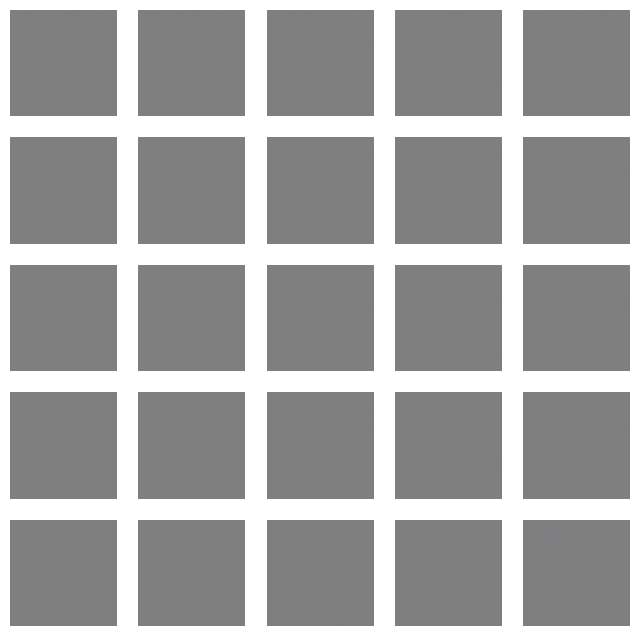

100 [Discriminator loss: 0.146131, acc.: 94.93%] [Generator loss: 0.236651]
200 [Discriminator loss: 0.003774, acc.: 99.97%] [Generator loss: 0.016423]
300 [Discriminator loss: 0.000695, acc.: 99.99%] [Generator loss: 0.000574]
400 [Discriminator loss: 0.000168, acc.: 100.00%] [Generator loss: 0.000009]
500 [Discriminator loss: 0.000066, acc.: 100.00%] [Generator loss: 0.000003]
1/1 [==============================] - 0s 19ms/step


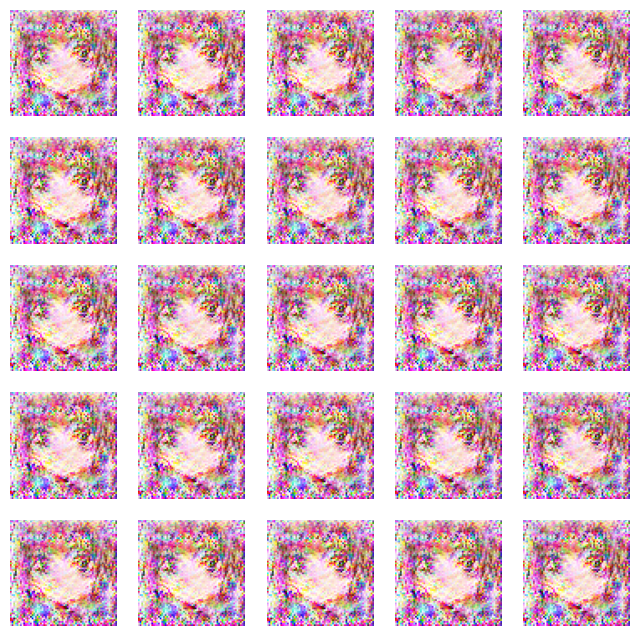

600 [Discriminator loss: 0.000049, acc.: 100.00%] [Generator loss: 0.000002]
700 [Discriminator loss: 0.000037, acc.: 100.00%] [Generator loss: 0.000002]
800 [Discriminator loss: 0.000035, acc.: 100.00%] [Generator loss: 0.000001]
900 [Discriminator loss: 0.000027, acc.: 100.00%] [Generator loss: 0.000001]
1000 [Discriminator loss: 0.000017, acc.: 100.00%] [Generator loss: 0.000001]
1/1 [==============================] - 0s 23ms/step


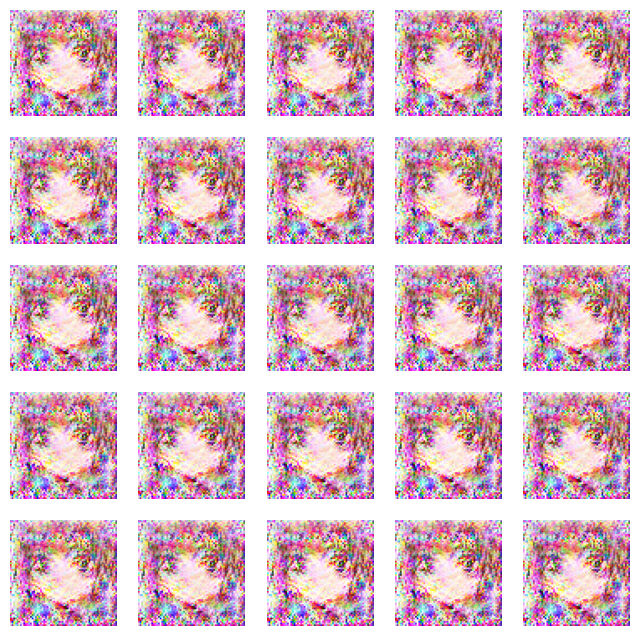

KeyboardInterrupt: ignored

In [29]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=100, save_images=500, save_model=15000)

* Обучение модели прервано принудительно по причине её "схлопывания"
* Модель получилась сильно недообученной: дискриминатор с самого начала получился сильно жёстким, не давая генератору возможности нормально обучаться.
* Функции потерь дискриминатора и генератора постепенно приближаются к нулю - модель останавливается в своём обучении
* Метрика Accuracy для дискриминатора составляет 100 - хорошо обучился отличать истинное изображенеие от сгенерированного
* Для того, чтобы исправить модель, необходимо изменить гиперпараметры - настройка оптимизатора Adam, Dropout минимум 0,5, изменение входных данных для генератора, изменить размер ядра свёртки в слоях дискриминатора
* Ввиду наличия в комрозиции 2х свёрточных сетей тренировка модели занимает несколько часов, подбор оптимальных гиперпараметров затруднён.